In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gc
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('./Binance_BTCUSDT_1h.csv', date_parser = True)
df = df.reindex(-np.sort(-np.arange(len(df))))
df.tail()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
4,1.638560e+12,2021/12/3 20:00,BTC/USDT,53838.66,54251.00,51680.00,53454.00,13628.15410,7.233171e+08,303617.0
3,1.638570e+12,2021/12/3 21:00,BTC/USDT,53453.99,54045.42,53333.33,53610.01,2836.73847,1.525043e+08,91636.0
2,1.638570e+12,2021/12/3 22:00,BTC/USDT,53610.00,53738.20,53029.98,53409.48,1927.67043,1.030645e+08,75676.0
1,1.638570e+12,2021/12/3 23:00,BTC/USDT,53409.48,53833.82,53310.55,53601.05,1069.47158,5.731913e+07,47349.0
0,1.638580e+12,2021/12/4 00:00,BTC/USDT,53601.05,53790.00,53502.87,53752.78,264.33564,1.417698e+07,9542.0


In [3]:
#擷取⽇期及收盤價
df2 = df.loc[:, ('date', 'close')] ; del df ; gc.collect()
#切出⽇期時間欄位，符號統⼀
df2['NewDate'] = df2.loc[:, 'date'].str.slice(start = 0, stop = 10).str.replace('-', '/').str.rsplit(pat=' ', n=1).apply(lambda x : x[0])
#判斷⽇期欄位格式
df2['AMPM'] = df2.loc[:, 'date'].str.contains(pat = 'AM|PM')
#依⽇期欄位格式切分兩分DF，有AMPM的在df3，正常格式的在df4
df3 = df2[df2['AMPM'] == 1]
df4 = df2[df2['AMPM'] == 0]
del df2 ; gc.collect()


23

In [4]:
#切出⽇期欄位中的⼩時
df3['Hour'] = df3.loc[:, 'date'].str.slice(start = 10, stop = 13).str.replace(':', '').apply(lambda x : pd.to_numeric(x))
df3['AMPM'] = df3.loc[:, 'date'].str.slice(start = 14, stop = 16).apply(lambda x: 12 if (x == 'PM') else 0)
df3['24Hr'] = (df3['Hour'] + df3['AMPM'])
#轉換為24⼩時制
df3['24Hr'] = df3['24Hr'].apply(lambda x: (x == 24 and 12) or (x == 12 and '00') or x)
df3['24Hr'] = df3['24Hr'].apply(lambda x: '0'+str(x) if len(str(x)) == 1 else str(x))

#轉為時間格式
df3['NewDateTime'] = (df3['NewDate'] + ' ' +df3['24Hr'])
df3['NewDateTime'] = df3['NewDateTime'].apply(lambda x: pd.to_datetime(x, format = "%Y/%m/%d %H"))
#移除重複
df3 = df3[['close', 'NewDateTime']].drop_duplicates()
df3.head()

,close,NewDateTime
40303,4308.83,2017-08-17 04:00:00
40302,4315.32,2017-08-17 05:00:00
40301,4324.35,2017-08-17 06:00:00
40300,4349.99,2017-08-17 07:00:00
40299,4360.69,2017-08-17 08:00:00


In [5]:
#轉為時間格式並移除重複
df4['NewDateTime'] = df4['date'].apply(lambda x: pd.to_datetime(x, format = "%Y/%m/%d %H:%M"))
df4 = df4[['close', 'NewDateTime']].drop_duplicates()
df4.head()

,close,NewDateTime
14367,11801.17,2020-08-01 23:00:00
14365,11782.63,2020-08-02 00:00:00
14363,11942.55,2020-08-02 01:00:00
14361,11928.58,2020-08-02 02:00:00
14359,12000.00,2020-08-02 03:00:00


In [6]:
#合併df3、df4，並移除重複
df5 = pd.concat([df3, df4]) ; df6 = df5.drop_duplicates()
#確認刪除多少資料
print(len(df5), len(df6))
del (df3, df4, df5)
gc.collect()


40304 37656


0

In [7]:
#投報率
df6['returns']=df6['close']/df6['close'].shift(1)
df6['log_returns']=np.log(df6['returns'])
df6 = df6[df6['returns'].notna()]
# df6.dropna()
df6.head()

,close,NewDateTime,returns,log_returns
40302,4315.32,2017-08-17 05:00:00,1.001506,0.001505
40301,4324.35,2017-08-17 06:00:00,1.002093,0.002090
40300,4349.99,2017-08-17 07:00:00,1.005929,0.005912
40299,4360.69,2017-08-17 08:00:00,1.002460,0.002457
40298,4444.00,2017-08-17 09:00:00,1.019105,0.018925


In [8]:
#依照年份及週次分組
df6['Year'] = df6.loc[:, 'NewDateTime'].dt.year
df6['Week'] = df6.loc[:, 'NewDateTime'].dt.isocalendar().week
test = np.array(df6.groupby(['Year', 'Week']), dtype = object).T
#排除⻑度不為168的array
Array = np.empty([1, 168])
for i in range(0, len(np.array(test[1]))):
    if len(np.array(test[1][i]['close'])) == 168 :
        Array = np.append(Array, np.array(test[1][i]['close']).reshape(1, -1), axis = 0)

In [9]:
df6.head()

,close,NewDateTime,returns,log_returns,Year,Week
40302,4315.32,2017-08-17 05:00:00,1.001506,0.001505,2017,33
40301,4324.35,2017-08-17 06:00:00,1.002093,0.002090,2017,33
40300,4349.99,2017-08-17 07:00:00,1.005929,0.005912,2017,33
40299,4360.69,2017-08-17 08:00:00,1.002460,0.002457,2017,33
40298,4444.00,2017-08-17 09:00:00,1.019105,0.018925,2017,33


In [17]:
data_training = df6[df6['Week']%4!=0].copy()
data_training = data_training[data_training['NewDateTime']> '2021-01-01'].copy()
data_training

,close,NewDateTime,returns,log_returns,Year,Week
8074,29409.99,2021-01-01 01:00:00,1.014308,0.014207,2021,53
8073,29194.65,2021-01-01 02:00:00,0.992678,-0.007349,2021,53
8072,29278.40,2021-01-01 03:00:00,1.002869,0.002865,2021,53
8071,29220.31,2021-01-01 04:00:00,0.998016,-0.001986,2021,53
8070,29187.01,2021-01-01 05:00:00,0.998860,-0.001140,2021,53
...,...,...,...,...,...,...
125,54617.85,2021-11-28 19:00:00,1.009404,0.009360,2021,47
124,54918.51,2021-11-28 20:00:00,1.005505,0.005490,2021,47
123,56273.23,2021-11-28 21:00:00,1.024668,0.024368,2021,47
122,56029.82,2021-11-28 22:00:00,0.995674,-0.004335,2021,47


In [18]:
data_test = df6[df6['Week']%4==0].copy()
data_test = data_test[data_test['NewDateTime']> '2021-01-01'].copy()
data_test

,close,NewDateTime,returns,log_returns,Year,Week
7499,32574.71,2021-01-25 00:00:00,1.009759,0.009711,2021,4
7498,32864.98,2021-01-25 01:00:00,1.008911,0.008871,2021,4
7497,32768.23,2021-01-25 02:00:00,0.997056,-0.002948,2021,4
7496,33568.18,2021-01-25 03:00:00,1.024412,0.024119,2021,4
7495,33378.93,2021-01-25 04:00:00,0.994362,-0.005654,2021,4
...,...,...,...,...,...,...
4,53454.00,2021-12-03 20:00:00,0.992856,-0.007170,2021,48
3,53610.01,2021-12-03 21:00:00,1.002919,0.002914,2021,48
2,53409.48,2021-12-03 22:00:00,0.996259,-0.003748,2021,48
1,53601.05,2021-12-03 23:00:00,1.003587,0.003580,2021,48


In [19]:
training_data = data_training.drop(['NewDateTime', 'Year','Week'], axis = 1)
training_data.head()

,close,returns,log_returns
8074,29409.99,1.014308,0.014207
8073,29194.65,0.992678,-0.007349
8072,29278.40,1.002869,0.002865
8071,29220.31,0.998016,-0.001986
8070,29187.01,0.998860,-0.001140


In [20]:
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)
training_data

array([[0.01034423, 0.53011421, 0.55003272],
       [0.00491097, 0.39641724, 0.41582714],
       [0.00702408, 0.45940696, 0.47941703],
       ...,
       [0.68813242, 0.59414991, 0.61330164],
       [0.68199092, 0.41493894, 0.43459282],
       [0.71340511, 0.57902819, 0.59841887]])

In [21]:
X_train = []
Y_train = []

In [22]:
training_data.shape[0]

6115

In [23]:
for i in range(168, training_data.shape[0]):
    X_train.append(training_data[i-168:i])
    Y_train.append(training_data[i,0])

In [24]:
X_train, Y_train = np.array(X_train), np.array(Y_train)

In [25]:
X_train.shape

(5947, 168, 3)

In [26]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [27]:
regressor = Sequential()
regressor.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 3)))
regressor.add(Dropout(0.2))

In [28]:
regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 120, activation = 'relu'))
regressor.add(Dropout(0.5))

regressor.add(Dense(units =1))

In [29]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 168, 50)           10800     
_________________________________________________________________
dropout (Dropout)            (None, 168, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 168, 60)           26640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 168, 60)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 168, 80)           45120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 168, 80)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               9

In [31]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [32]:
regressor.fit(X_train, Y_train, epochs = 20, batch_size =50)

Epoch 1/20
119/119 [==============================] - 239s 2s/step - loss: 0.0278
Epoch 2/20
119/119 [==============================] - 232s 2s/step - loss: 0.0078
Epoch 3/20
119/119 [==============================] - 226s 2s/step - loss: 0.0068
Epoch 4/20
119/119 [==============================] - 225s 2s/step - loss: 0.0065
Epoch 5/20
119/119 [==============================] - 224s 2s/step - loss: 0.0061
Epoch 6/20
119/119 [==============================] - 224s 2s/step - loss: 0.0056
Epoch 7/20
119/119 [==============================] - 225s 2s/step - loss: 0.0053
Epoch 8/20
119/119 [==============================] - 224s 2s/step - loss: 0.0047
Epoch 9/20
119/119 [==============================] - 223s 2s/step - loss: 0.0048
Epoch 10/20
119/119 [==============================] - 224s 2s/step - loss: 0.0043
Epoch 11/20
119/119 [==============================] - 224s 2s/step - loss: 0.0040
Epoch 12/20
119/119 [==============================] - 224s 2s/step - loss: 0.0037
Epoch 13/20
1

In [33]:
 regressor.save("LSTM_model_1205.h5")

In [35]:
past_60_days = data_training.tail(60)
df= past_60_days.append(data_test, ignore_index = True)
df = df.drop(['NewDateTime', 'Year','Week'], axis = 1)
df.head()

,close,returns,log_returns
0,54299.98,1.010810,0.010752
1,54595.12,1.005435,0.005421
2,54644.69,1.000908,0.000908
3,54341.55,0.994453,-0.005563
4,54275.13,0.998778,-0.001223


In [36]:
inputs = scaler.transform(df)
inputs

array([[0.63834522, 0.50849022, 0.52852162],
       [0.64579191, 0.47527193, 0.49533129],
       [0.64704262, 0.44728753, 0.46723248],
       ...,
       [0.61587695, 0.4185547 , 0.43824962],
       [0.62071047, 0.46384587, 0.48387383],
       [0.62453878, 0.4591724 , 0.47918144]])

In [40]:
X_test = []
Y_test = []
for i in range (168, inputs.shape[0]):
    X_test.append(inputs[i-168:i])
    Y_test.append(inputs[i, 0])

In [41]:
X_test, Y_test = np.array(X_test), np.array(Y_test)
X_test.shape, Y_test.shape

((1852, 168, 3), (1852,))

In [42]:
Y_pred = regressor.predict(X_test)
Y_pred, Y_test

(array([[0.21225232],
        [0.22252646],
        [0.23297988],
        ...,
        [0.5909193 ],
        [0.58245444],
        [0.57596236]], dtype=float32),
 array([0.22304414, 0.23338787, 0.20332404, ..., 0.61587695, 0.62071047,
        0.62453878]))

In [43]:
scaler.scale_

array([2.52310661e-05, 6.18111179e+00, 6.22605758e+00])

In [44]:
scale = 1/2.52310661e-05
scale

39633.68000530108

In [45]:
Y_test = Y_test*scale
Y_pred = Y_pred*scale

In [46]:
Y_pred


array([[ 8412.341],
       [ 8819.542],
       [ 9233.85 ],
       ...,
       [23420.307],
       [23084.812],
       [22827.508]], dtype=float32)

In [47]:
Y_test

array([ 8840.06000118,  9250.02000124,  8058.48000108, ...,
       24409.47000326, 24601.04000329, 24752.77000331])

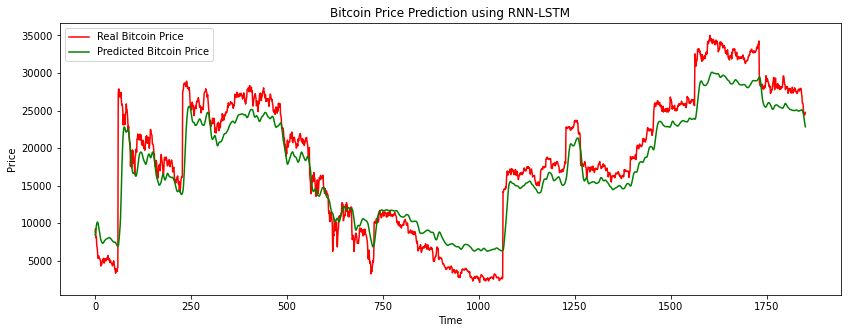

In [48]:
plt.figure(figsize=(14,5))
plt.plot(Y_test, color = 'red', label = 'Real Bitcoin Price')
plt.plot(Y_pred, color = 'green', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()